In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

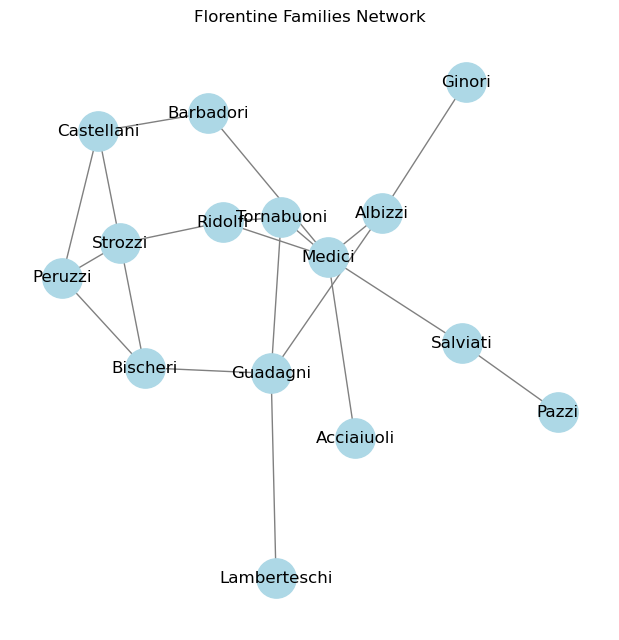

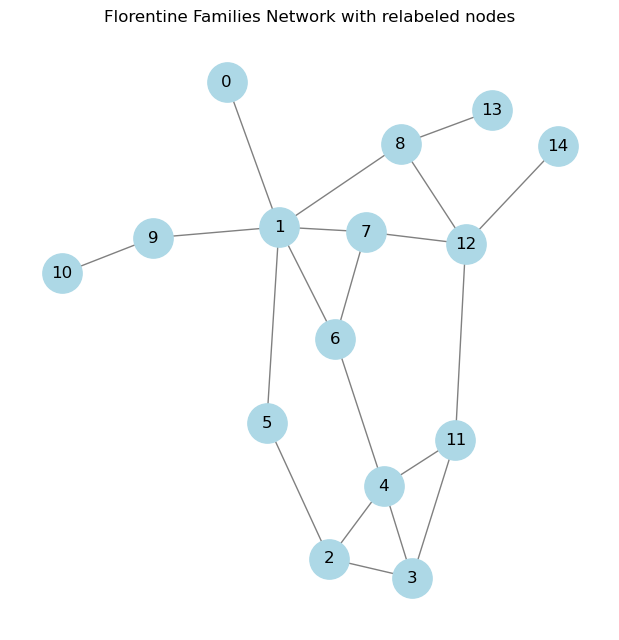

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


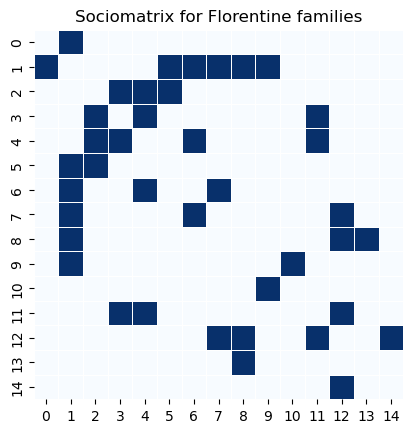

In [5]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

# Latent space

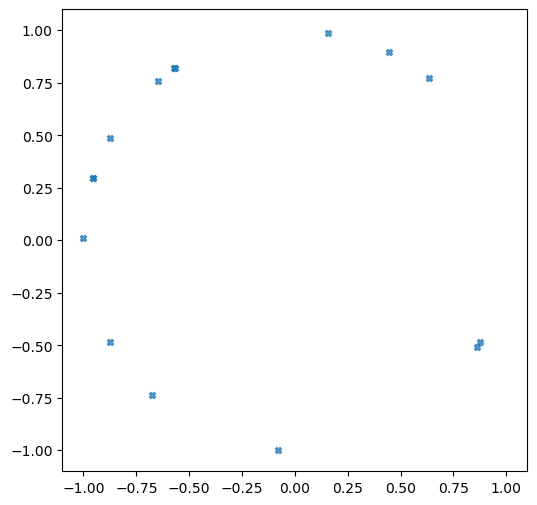

In [83]:
n = len(G.nodes)

angles = 2*np.pi*np.random.rand(n)
Z_init_r = np.stack((np.cos(angles), np.sin(angles)), axis=1)

plt.figure(figsize=(6,6))
plt.scatter(Z_init_r[:, 0], Z_init_r[:, 1], s=20, alpha=0.7,marker="X")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

# Likelihood

-241.42758860001325
-192.6710531801178


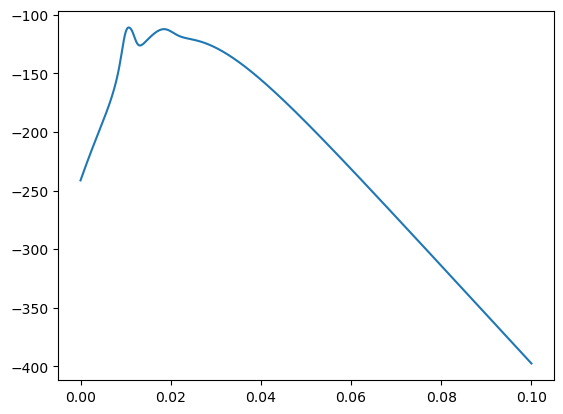

In [159]:
def loglikelihood(G,Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            dist = Z[i].T @ Z[j]
            eta = a + dist
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

def grad_loglikelihood(G,Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = Z[i].T @ Z[j]
                eta = a + dist 
                grad_Z[i,:] +=  (y-expit(eta)) *  (Z[j])
                grad_a += (y-expit(eta)) * (1) 
    return grad_Z, grad_a

def update_Z(Z, grad_Z):
    for i in range(len(Z)):
        proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
        Z[i] = Z[i] + proj_orth 
        Z[i] = Z[i] / np.linalg.norm(Z[i])
    return Z

grad_Z,  grad_a = grad_loglikelihood(G,Z_init_r,0.1)
lr = 0.005
print(loglikelihood(G,Z_init_r,0.1))
print(loglikelihood(G,update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(G,update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

In [119]:
def SearchingMLE(G, Z_init, a_init, max_iter=1000, tol=1e-10, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(G, Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(G, update_Z(Z0, alpha*grad_Z) ,a0 + alpha*grad_a) < loglikelihood(G, Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = update_Z(Z0, alpha*grad_Z) 
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)

        #if alpha * np.linalg.norm(grad_Z) < tol and alpha * np.abs(grad_a) < tol:
        #    break
    
    return  Z0, a0, historyZ, historya

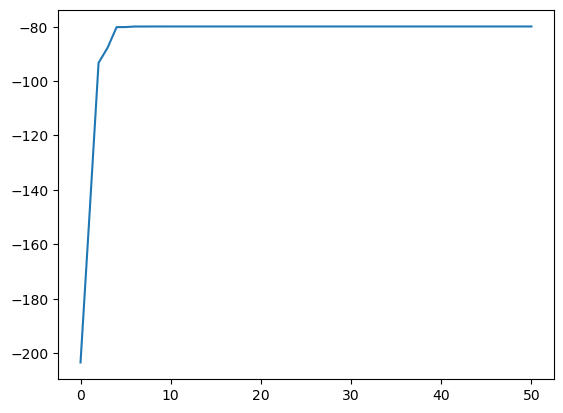

In [160]:
angles_rand = 2*np.pi*np.random.rand(n)
Z_init_MLE = np.stack((np.cos(angles_rand), np.sin(angles_rand)), axis=1)
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(G, Z_init_MLE ,np.random.randn(),50)
plt.plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

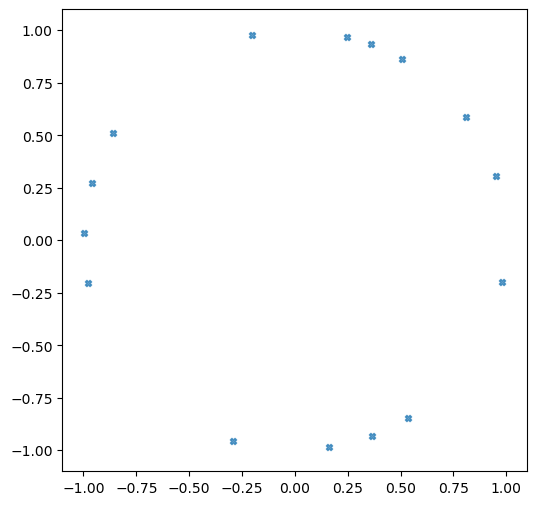

In [161]:
plt.figure(figsize=(6,6))
plt.scatter(Z_ML[:, 0], Z_ML[:, 1], s=20, alpha=0.7,marker="X")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

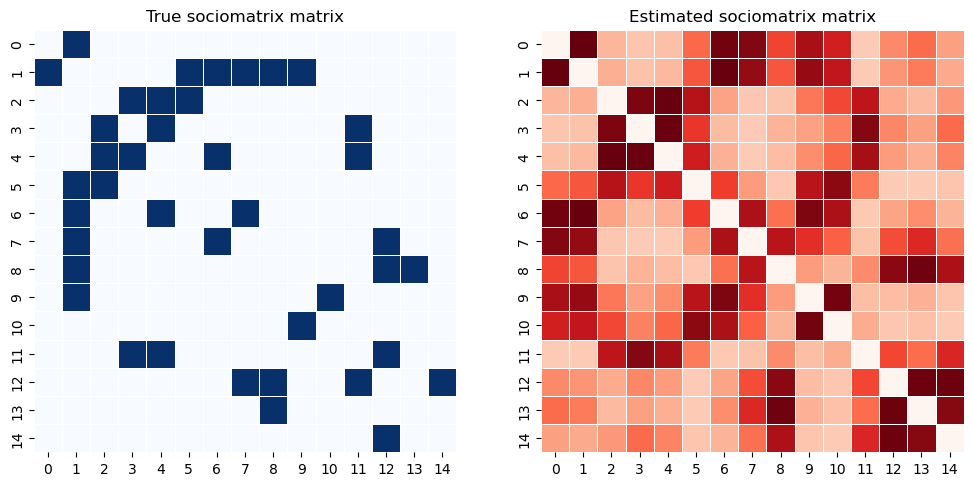

In [162]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j] 
            Y_MLE[i,j] = expit(a_ML + d)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Prior distribution

3.667664212677602
-0.332335787322398


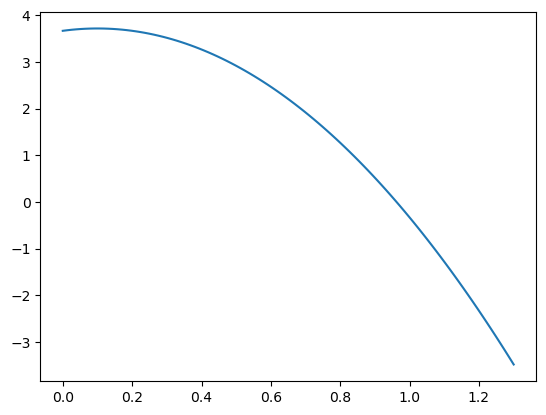

In [238]:
def logpriori(G, Z,a,var=0.1):
    logpriorZ = 0.0
    for i in range(len(Z)):
        logpriorZ +=  - 10*(Z[i].T @ Z[i] -1)**2
    logpriora = 0.5 * a**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorZ + logpriora)


def grad_logpriori(G, Z,a,var=0.1):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = 20 * Z[i] * (Z[i].T @ Z[i] -1) 
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

grad_Z,  grad_a = grad_logpriori(G, Z_init_r,0.1)
lr = 1.0
print(logpriori(G, Z_init_r,0.1))
print(logpriori(G, update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,1.3,100),[logpriori(G, update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,1.3,100)])
plt.show()

# Potential Energy

231.02192002196298
249.2391539993384


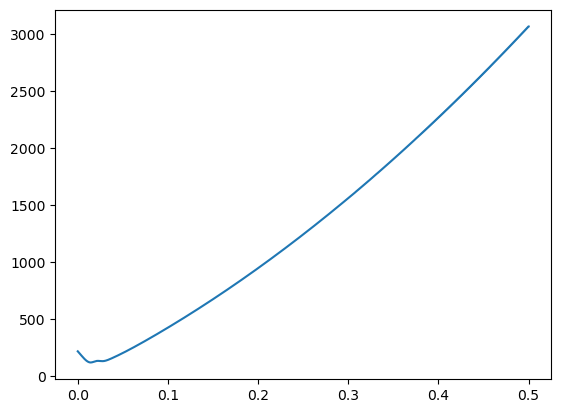

In [239]:
def U(G, Z,a,var=1):
    return (-1) * (loglikelihood(G, Z,a) + logpriori(G, Z,a,var))

def grad_U(G, Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(G, Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(G, Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

grad_Z,  grad_a = grad_U(G, Z_init_r,0.1)
lr = 0.06
print(U(G, Z_init_r,0.1))
print(U(G, update_Z(Z_init_r, -lr*grad_Z),0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.5,1000),[U(G, update_Z(Z_init_r, -lr*grad_Z),0.1-lr*grad_a) for lr in np.linspace(0.0,0.5,1000)])
plt.show()

In [218]:
def grad_U_i(G,Z,a,i,var=1):
    grad_Z_i = np.zeros(Z.shape[1])
    for j in G.nodes():
        if j != i:
            y = 1.0 if j in G.neighbors(i) else 0.0
            dist = Z[i].T @ Z[j]
            eta = a + dist 
            grad_Z[i,:] +=  (y-expit(eta)) *  (Z[j])
    grad_Z_i += (-1) * Z[i,:] / var
    return -grad_Z_i


def grad_U_a(G,Z,a,var=1):
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = Z[i].T @ Z[j]
                eta = a + dist
                grad_a += (y-expit(eta))
    grad_a += (-1) * a / var 
    return -grad_a

## Applying Hamiltonian Monte Carlo Algorithm

In [ ]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta
def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi  # Evita división por cero
    return new_theta, new_phi
def compute_star(Old, Ref):
    ang_old = np.arctan2(Old[:,1], Old[:,0])
    ang_ref = np.arctan2(Ref[:,1], Ref[:,0])
    
    addition = np.mean(ang_ref-ang_old)
    
    ang_new = ang_old + addition

    #print("Addition: ", addition)
    New = np.zeros_like(Old)
    New[:,0] = np.cos(ang_new)
    New[:,1] = np.sin(ang_new)
    return New 

def ghmc(G, Z_init, a_init, num_samples, epsilon_init=0.05, std_dev_init=1.0, percentage_warmup=0.2):
    """
    Hamiltonian Monte Carlo (HMC) sampling algorithm.
    Parameters:
    - G: Graph object.
    - Z_init: Initial value for Z.
    - a_init: Initial value for a.
    - num_samples: Number of samples to generate.
    - epsilon_init: Initial step size for the leapfrog integrator.
    - std_dev_init: Standard deviation for the momentum variable.
    - percentage_warmup: Percentage of samples to use for warmup.
    Returns:
    - samples_Z: Generated samples for Z.
    - samples_a: Generated samples for a.
    - Hamiltonian_p: Hamiltonian values for each sample.
    - LogL: Log-likelihood values for each sample.
    - acep_rate_history: Acceptance rate history.
    """

    
    number_of_parameters = Z_init.shape[0] + 1
    warmup = int(num_samples * percentage_warmup)
    number_of_iterations = num_samples + warmup
    print(f"Number of samples: {num_samples}")
    print(f"Number of parameters: {number_of_parameters}")
    print(f"Number of iterations: {number_of_iterations}")
    print(f"Number of warmup iterations: {warmup}")
   

    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(G,Z_init,a_init)]
    LogL = [loglikelihood(G,Z_init,a_init)]
    # Parámetros adaptativos
    epsilon = epsilon_init
    std_dev = std_dev_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(number_of_iterations)
    
    for iter in tqdm(range(number_of_iterations)):

        Z = samples_Z[-1].copy()
        a = samples_a[-1].copy()


        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 2 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.80:
                epsilon = np.max(np.array([0.005,0.99*epsilon])) 
                std_dev = np.max(np.array([0.05,0.99*std_dev]))
            elif current_accept_rate > 0.60:
                epsilon = np.min(np.array([0.2,1.01*epsilon]))
                std_dev = np.min(np.array([0.75,1.01*std_dev]))
            L = max(1, int(round(1/epsilon)))  # Actualizar L
        elif iter == warmup:
            print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")



        


        ### GHMC algorithm for Z

        for i in range(Z.shape[0]):
            Z_i = Z[i].copy()
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            p_i = project_to_tangent_space(Z_i, p_i)
            current_p = p_i.copy()

            #Leapfrog integration
            grad_Z,  grad_a = grad_U(G, Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2 
            p_i = project_to_tangent_space(Z_i, p_i)       
            for _ in range(L):
                Z_i, p_i = geodesic_flow(Z_i, p_i, epsilon)
            Z[i] = Z_i.copy()
            grad_Z,  grad_a = grad_U(G, Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2
            p_i = project_to_tangent_space(Z_i, p_i)

            

            # Hamiltonian
            current_U = U(G, samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(G, Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if np.log(np.random.rand()) < log_accept_ratio:
                samples_a.append(samples_a[-1])
                samples_Z.append(Z.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(G, Z,samples_a[-1]))
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
                LogL.append(LogL[-1])
            total_updates += 1   

            grad_Z,  grad_a = grad_U(G, samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(G, samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2

        # Hamiltonian
        current_U = U(G, samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(G, samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if np.log(np.random.rand()) < log_accept_ratio:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(G, samples_Z[-1],a))
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
            LogL.append(LogL[-1])
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    
    # Choose valid samples
    ## Remove warmup samples
    samples_Z = np.array(samples_Z[1:])[warmup*number_of_parameters:-1:number_of_parameters,:,:]
    samples_a = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a[1:]])[warmup*number_of_parameters:-1:number_of_parameters]
    Hamiltonian_p = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p[1:]])[warmup*number_of_parameters:-1:number_of_parameters]
    LogL = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in LogL[1:]])[warmup*number_of_parameters:-1:number_of_parameters]

    return samples_Z, samples_a, Hamiltonian_p, LogL, acep_rate_history



In [ ]:
# Execute HMC
number_of_samples = 2000
angles = 2*np.pi*np.random.rand(n)
Z_init = np.stack((np.cos(angles), np.sin(angles)), axis=1)
a_init = np.random.randn(1)


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init)[0])

samples_Z, samples_a, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, number_of_samples, epsilon_init=0.1, std_dev_init=0.1, percentage_warmup=0.2)
samples_Z = [compute_star(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -79.92130458599597
Log-L starter: -119.98938190962262
Number of samples: 2000
Number of parameters: 16
Number of iterations: 2400
Number of warmup iterations: 400


 17%|█▋        | 400/2400 [01:53<08:56,  3.73it/s]

Final parameters: epsilon=0.1755, L=6, std_dev=0.5585


100%|██████████| 2400/2400 [10:45<00:00,  3.72it/s]

Acceptance rate: 0.52997
Log-L MAP: -83.34022725736976
Log-L CM: -102.13074703252812


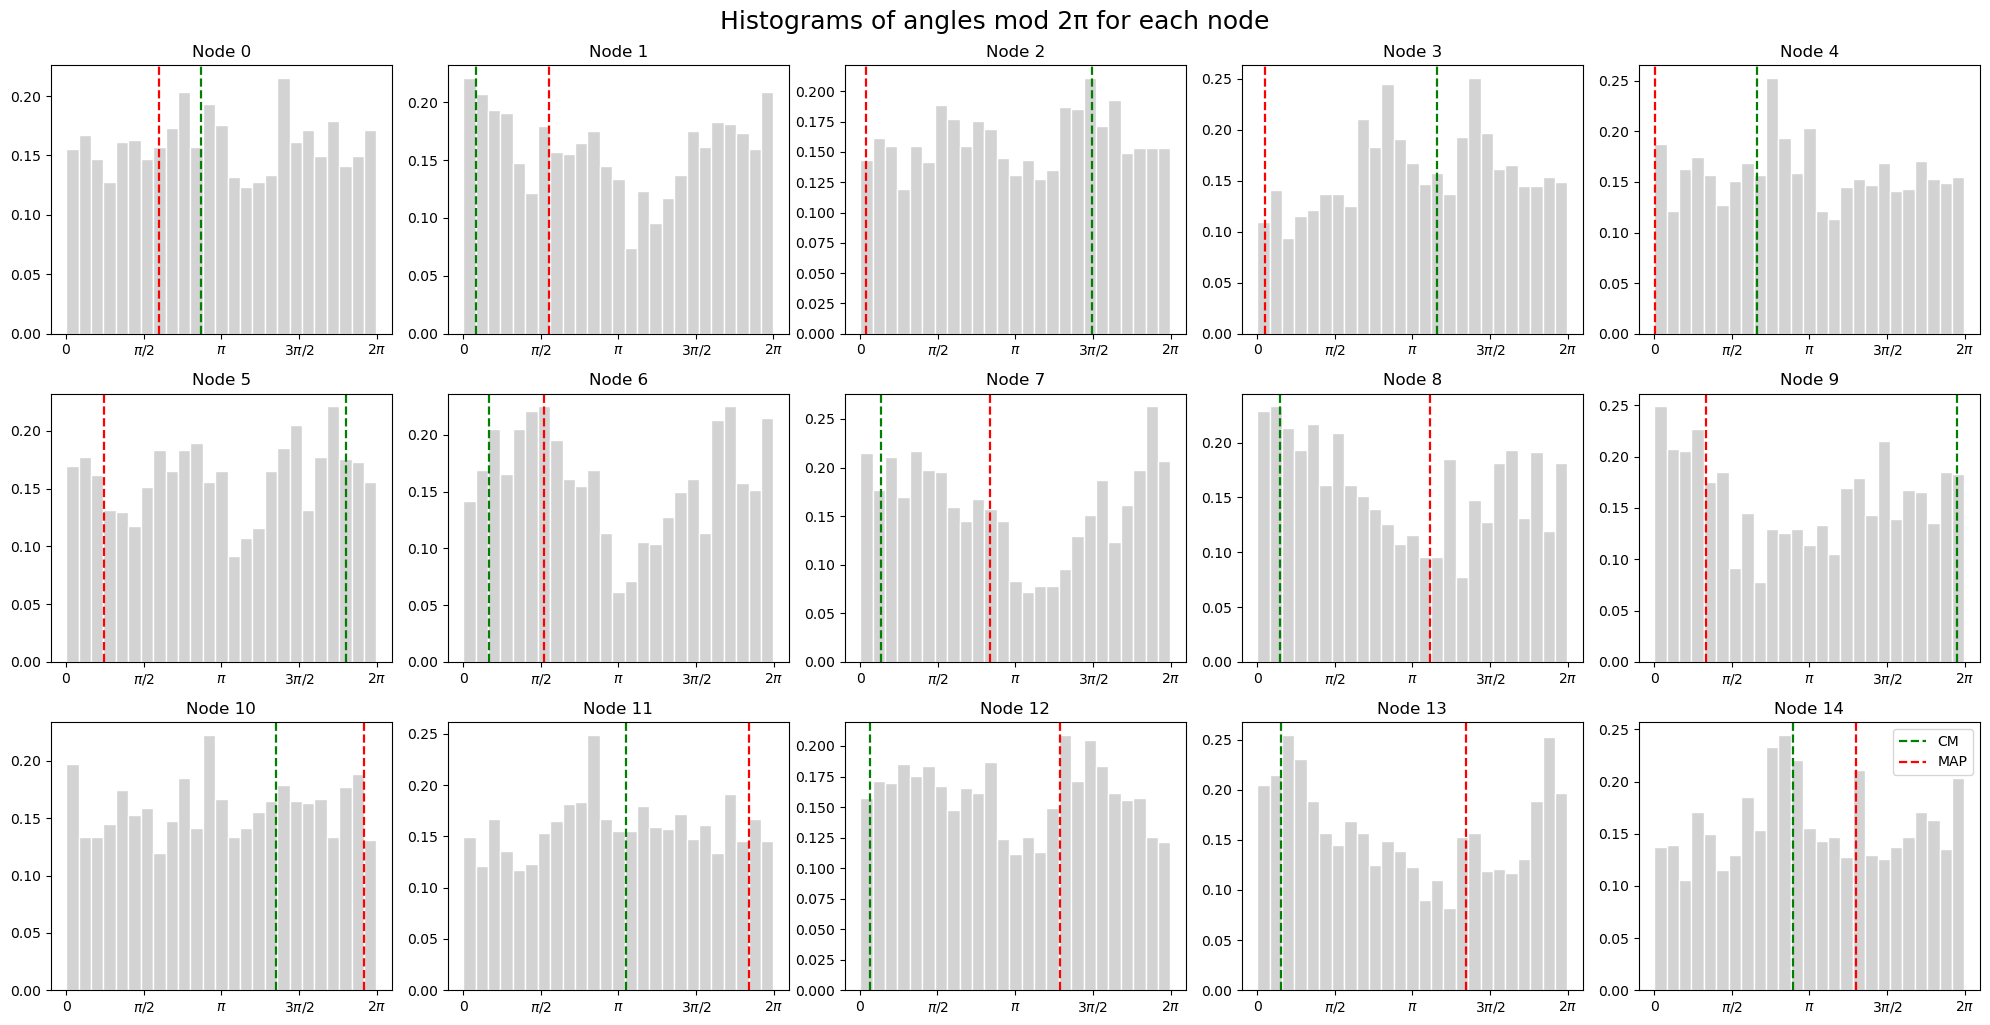

In [345]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))  # 3 filas x 5 columnas
axes = axes.flatten() 

for i in range(n):
    ax = axes[i]
    # Ángulo polar mod 2π
    angles = np.mod(np.arctan2(samples_Z[:, i, 1], samples_Z[:, i, 0]), 2*np.pi)
    
    ax.hist(angles, bins=25, color='lightgray', edgecolor='white', density=True)
    ax.axvline(np.mod(np.arctan2(Z_CM[i, 1], Z_CM[i, 0]), 2*np.pi), color='green', linestyle='dashed', linewidth=1.6)
    ax.axvline(np.mod(np.arctan2(Z_MAP[i, 1], Z_MAP[i, 0]), 2*np.pi), color='red', linestyle='dashed', linewidth=1.6)
    ax.set_title(f'Node {i}')
    ax.set_xticks([0, np.pi/2, np.pi , 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$',r'$2\pi$'])
    ax.grid(False)
plt.legend(['CM','MAP'], loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of angles mod 2π for each node", y=1.02, fontsize=18) 
plt.show()

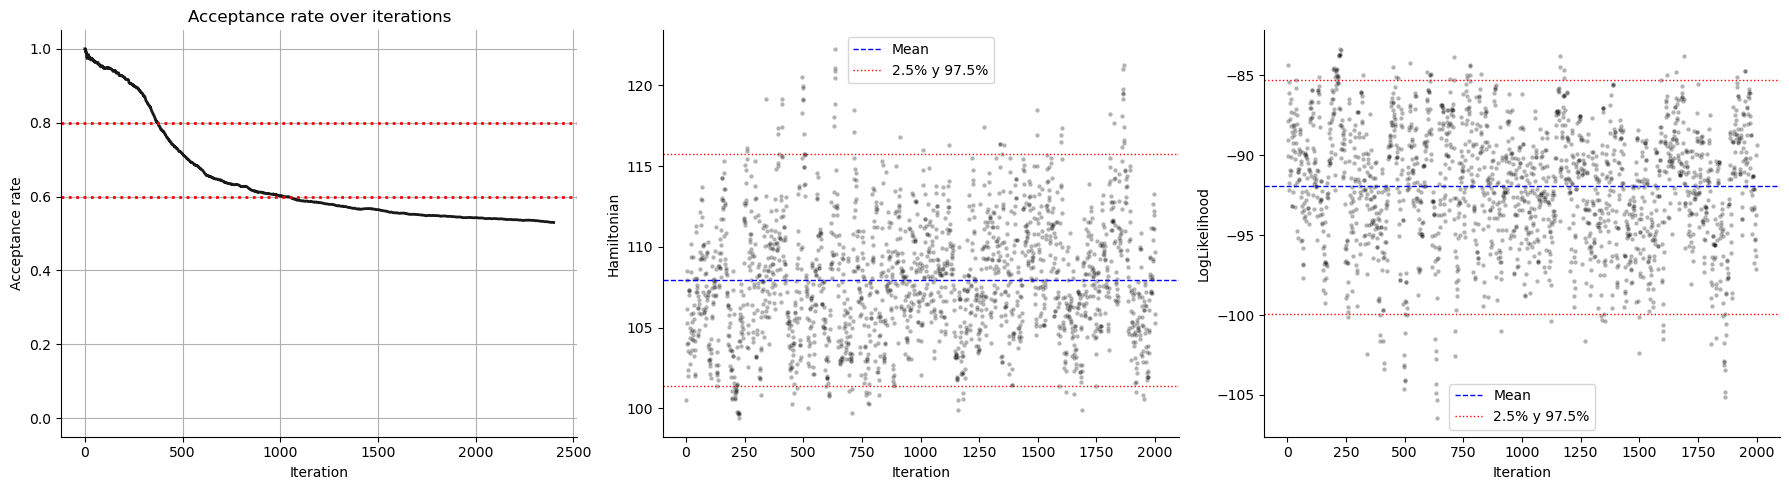

In [346]:
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({'Iteration': iterations1, 'Values': x1})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

x2 = LogLp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

# Crear figura 1x3
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# Subplot 1: Acceptance rate
axs[0].plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Acceptance rate")
axs[0].set_title("Acceptance rate over iterations")
axs[0].set_ylim(-0.05, 1.05)
axs[0].grid(True)

# Subplot 2: Hamiltonian
sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data1, color='black', alpha=0.3, s=10)
axs[1].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Hamiltonian")
axs[1].legend()

# Subplot 3: LogLikelihood
sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
axs[2].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[2].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[2].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("LogLikelihood")
axs[2].legend()

sns.despine()
plt.tight_layout()
plt.show()


c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


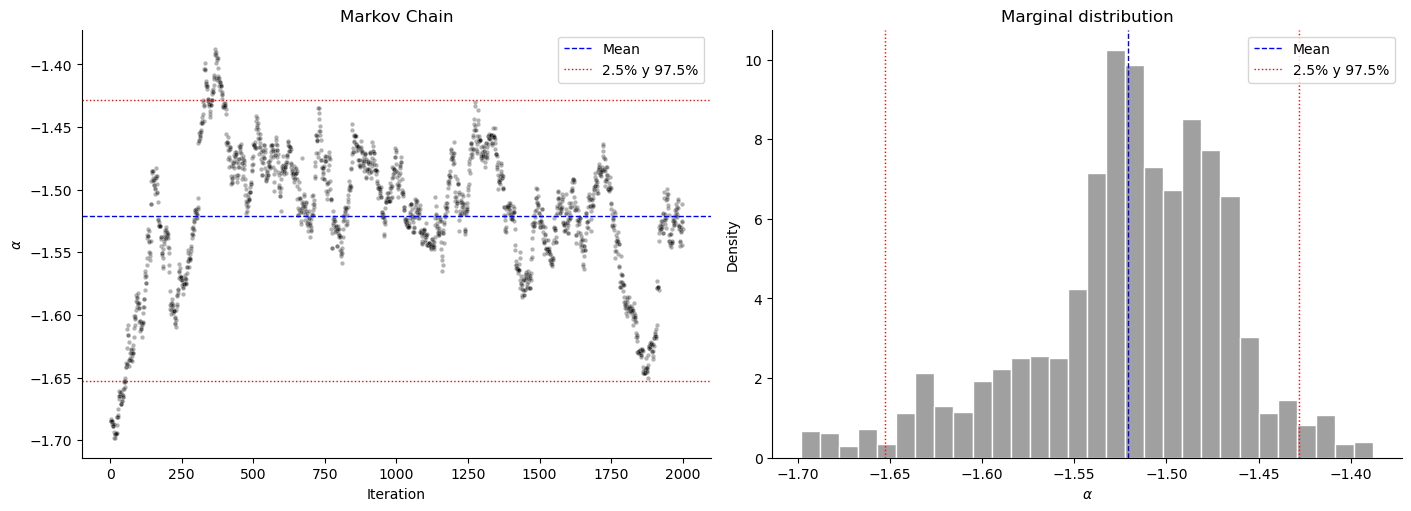

In [347]:
#
x = samples_a
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()